In [1]:
import matplotlib.pyplot as plt
import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
import os
from fastgres.analysis_utility.tools.ring_neighborhood_traversal import RingNeighborhoodTraversal
from fastgres.workloads.workload import Workload
from fastgres.baseline.hint_sets import Hint
from fastgres.baseline.utility import int_to_binary
import random
if os.getcwd() != "C:/Users/Jerome/PycharmProjects/FASTgres":
    os.chdir("C:/Users/Jerome/PycharmProjects/FASTgres")

In [39]:
workload_name = "job"
version = 12.4
a_path = f"fastgres/archives/{workload_name}/{version}/archive.json"
wl_path = f"fastgres/workloads/queries/{workload_name}/"
wl = Workload(wl_path, workload_name)
hints = [hint for hint in Hint]

{0: 1.7329, 8: 1.3783, 12: 1.2393, 28: 1.1802, 29: 1.1913, 61: 1.2184, 63: 1.232}
[8, 4, 16, 1, 32, 2]
[0, 1, 2, 4, 8, 16, 32, 9, 10, 12, 24, 40, 13, 14, 28, 44, 29, 30, 60, 31, 61, 63]


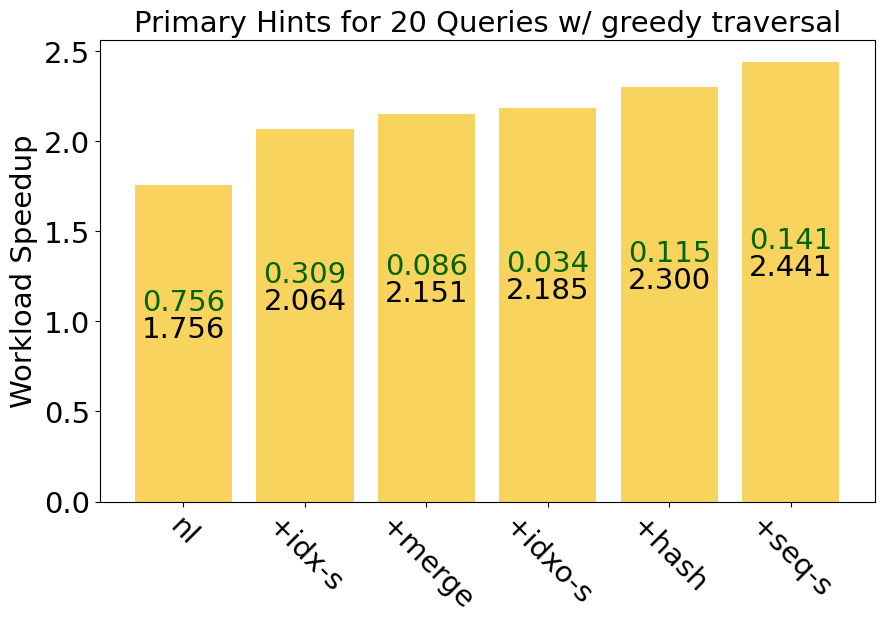

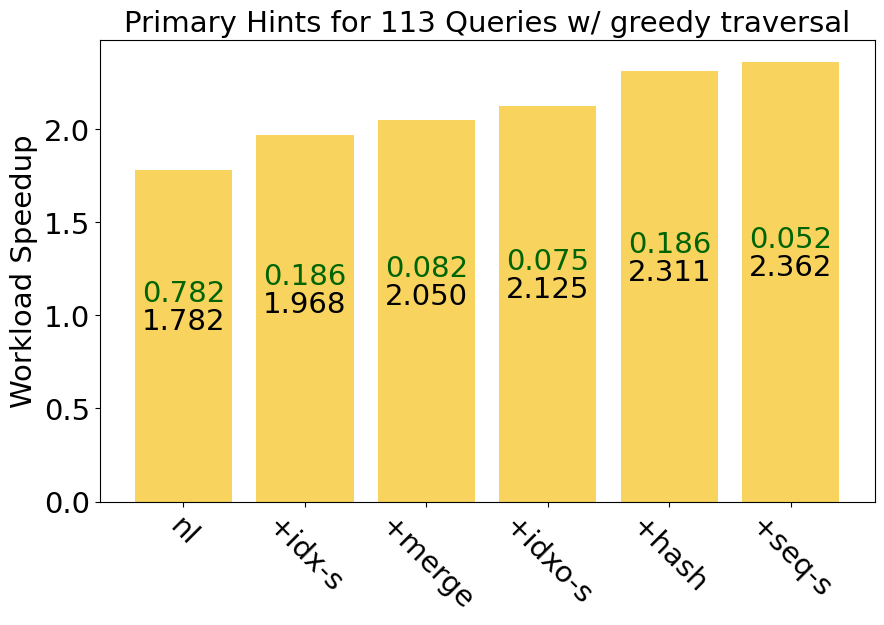

In [59]:
from fastgres.analysis_utility import tool
from fastgres.analysis_utility.tools.single_hint_optimization_influence import SingleHintOptimizationInfluence
from fastgres.analysis_utility.tool import TimeGranularity as Tg
query_names = wl.queries
# random.shuffle(query_names)
query_names = query_names[:20]

traversal = RingNeighborhoodTraversal(a_path, wl_path, query_names, hints, op_mode=RingNeighborhoodTraversal.OperationMode.ADD, spread=1)
traversed_hint_sets = traversal.traverse_hint_sets()
print(traversed_hint_sets)
# print(traversal.hints)
# [print(int_to_binary(_)) for _ in list(traversed_hint_sets.keys())[1:-1]]
sorted_hints = traversal.sort_by_inactive_hints(traversed_hint_sets)
# print(sorted_hints)
order = traversal.traversed_order(traversed_hint_sets)
print(order)
all_hint_sets = traversal.calculate_one_ring_of_order([Hint(idx) for idx in order])
print(all_hint_sets)

# plt.show()
influence = SingleHintOptimizationInfluence(a_path, wl_path, query_names, order, time_granularity=Tg.HOURS, plot_diff=True)
influence.set_properties(ylabel_left="Workload Speedup", ylabel_right="Labeling Time", title_left=f"Primary Hints for {len(query_names)} Queries w/ greedy traversal")
influence.show()
influence = SingleHintOptimizationInfluence(a_path, wl_path, wl.queries, order, time_granularity=Tg.HOURS, plot_diff=True, use_pseudo_dict=True)
influence.set_properties(ylabel_left="Workload Speedup", ylabel_right="Labeling Time", title_left=f"Primary Hints for {len(wl.queries)} Queries w/ greedy traversal")
influence.show()

# Finding the best hint set greedily

In [5]:
from fastgres.analysis_utility.tools.single_hint_optimization_influence import SingleHintOptimizationInfluence
from fastgres.analysis_utility.tool import TimeGranularity as Tg
query_names = wl.queries
random.shuffle(query_names)
query_slice = query_names[:1]

traversal = RingNeighborhoodTraversal(a_path, wl_path, query_slice, hints, op_mode=RingNeighborhoodTraversal.OperationMode.SUB, spread=1)

traversed_hint_sets = traversal.traverse_hint_sets()
print(traversed_hint_sets)
order = traversal.traversed_order(traversed_hint_sets)
print(order)
all_hint_sets = traversal.calculate_one_ring_of_order([Hint(idx) for idx in order])
print(all_hint_sets)
test_dict = {h_set: round(traversal._used_dict[query_slice[0]][str(h_set)], 4) for h_set in all_hint_sets}
print(test_dict)

sorted_dict = dict(sorted(traversed_hint_sets.items(), key=lambda item: item[1]))
best_key = list(sorted_dict.keys())[0]
best_time = sorted_dict[best_key]

opt = tool.get_opt_hint_sets(traversal.archive, query_slice)[0]

print(best_key, opt)
print(best_time, round(traversal.archive[query_slice[0]][str(opt)], 4))

{63: 0.0264, 59: 0.0101, 27: 0.0076, 26: 0.0076, 18: 0.0076, 2: 0.0073, 0: 0.0073}
[4, 32, 1, 8, 16, 2]
[63, 62, 61, 59, 55, 47, 31, 58, 57, 51, 43, 27, 26, 25, 19, 11, 24, 18, 10, 16, 2, 0]
{63: 0.0264, 62: 0.037, 61: 0.0114, 59: 0.0101, 55: 1, 47: 0.0496, 31: 0.0308, 58: 0.0101, 57: 0.0101, 51: 0.01, 43: 0.0275, 27: 0.0076, 26: 0.0076, 25: 0.0372, 19: 0.0076, 11: 0.0076, 24: 0.0077, 18: 0.0076, 10: 0.0076, 16: 0.0076, 2: 0.0073, 0: 0.0073}
2 8
0.0073 0.0073


# Interpolation Influence on Erroneous Results

In [6]:
from fastgres.analysis_utility import tool
import pandas as pd
query_names = wl.queries

query_res = pd.DataFrame(columns=["res", "opt", "hit", "interp"])
traversal = RingNeighborhoodTraversal(a_path, wl_path, [query_names], hints, op_mode=RingNeighborhoodTraversal.OperationMode.SUB, spread=1)

for query_name in query_names:
    traversal.query_names = [query_name]
    traversed_hint_sets = traversal.traverse_hint_sets()
    order = traversal.traversed_order(traversed_hint_sets)
    all_hint_sets = traversal.calculate_one_ring_of_order([Hint(idx) for idx in order])
    
    test_dict = {h_set: round(traversal._used_dict[query_names[0]][str(h_set)], 4) for h_set in all_hint_sets}
    sorted_dict = dict(sorted(traversed_hint_sets.items(), key=lambda item: item[1]))
    best_key = list(sorted_dict.keys())[0]
    best_time = sorted_dict[best_key]
    
    opt = tool.get_opt_hint_sets(traversal.archive, [query_name])[0]
    hit = True if best_key == opt else False
    res = str(best_key)
    opt = str(opt)

    try: 
        _ = traversal.archive[query_name][str(best_key)]
        interp = False
    except KeyError:
        interp = True
        
    query_res.loc[len(query_res.index)] = res, opt, hit, interp

In [7]:
import numpy as np
print(query_res.head())
print("Opt Hit Ratio: ", round((query_res[query_res["hit"]==True].shape[0] / len(query_names)) * 100, 1), "%")
res_h = query_res["res"].to_numpy()
opt_h = query_res["opt"].to_numpy() 
res = np.array([traversal._used_dict[query_names[i]][res_h[i]] for i in range(len(query_names))])
opt = np.array([traversal._used_dict[query_names[i]][opt_h[i]] for i in range(len(query_names))])
error = sum(res-opt)
pg_def = np.array([traversal._used_dict[query_names[i]]["63"] for i in range(len(query_names))])
print(f"Pg Default: {round(sum(pg_def), 4)} / "
      f"Heuristic: {round(sum(res), 4)} / "
      f"Opt: {round(sum(opt), 4)}")
print(f"Error margin: {abs(round(error, 4))}s")
interp = query_res[query_res["interp"]==True].shape[0]
interp_p = round((interp / len(query_names)) * 100, 1)
print(f"Results use {interp} interpolated values ({interp_p}%).")
no_hit_no_interp = query_res[(query_res["interp"]==False) & (query_res["hit"]==False)]
print(f"Non-optimal, non-interpolated entries: {no_hit_no_interp.shape[0]}")

  res opt    hit  interp
0   2   8  False    True
1  14  14   True   False
2  59  60  False    True
3  11  15  False    True
4  31  31   True   False
Opt Hit Ratio:  58.6 %
Pg Default: 19384.0215 / Heuristic: 7234.2082 / Opt: 7234.2075
Error margin: 0.0008s
Results use 2543 interpolated values (41.1%).
Non-optimal, non-interpolated entries: 20
